<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Natural Language Processing Challenge (Part 2)


---

## Problem Statement


Our company is currently building a new wellness and mindfulness app to help promote better mental health. The app aims to provide thought of the day based on natural philosophies such as Buddhism and Stoicism. As a start, everyday, the app will allow the user to write one sentence against a prompt on certain topics. The app will then assess if the user is more in line with Buddhist or Stoic philosophies, and in return decide to return either Buddhist advice or Stoic advice based on the prompt written.

To train the app to gain an understanding of the types of people who will be more aligned with Buddhist or Stoic philosophies, we will be using posts from the subreddits r/Buddhism and r/Stoicism to machine train our model to distinguish and classify posts from the different subreddits.


# Content Page

---


# Datasets


- ['subreddit_posts'](./subreddit_posts.csv): Subreddit Posts


In Part 1, we collected our datasets through webscrapping the data. In Part 2, we will perform data cleaning and EDA, and come up with a train a binary classification modelling system.


# Importing Libraries


In [10]:
# Importing Libraries


# Data Frame
import pandas as pd

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Data Processing
import joblib
import numpy as np
import re
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier


# NLP
import nltk
from nltk.corpus import stopwords
import wordcloud
from nltk.stem import WordNetLemmatizer
from collections import Counter


# Warnings Suppressions
import warnings
warnings.filterwarnings('ignore')


In [11]:
# Set Pandas Options

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", None)

# Set Seaborn options
sns.set(style='ticks', context='talk')
plt.style.use('dark_background')


We will be importing our webscrapped text data into a dataframe for analysis.


In [12]:
# Import webscrapped data

subreddit_posts = pd.read_csv("subreddit_posts.csv")

subreddit_posts.head()


,subreddit,title,selftext
0,Buddhism,Favorite teaching stories on the topic of Work as Meditation Practice?,I know I've heard some good stories related to **work as Buddhist practice** from different traditions over the years and would love to hear the stories that others in this community have collected or remembered over the years too.\n\nI'll submit some of my favorites in the comments below too... Thanks (in advance) for sharing!\n\n&amp;#x200B;\n\n&amp;#x200B;\n\nhttps://preview.redd.it/y6l7neqhfw291.jpg?width=2048&amp;format=pjpg&amp;auto=webp&amp;s=d8d8426d9d2132ee8737cdae0432dc73b2ad646b
1,Buddhism,"If you could ask our Buddha one question, what would it be?","For example, clarification whether our current iterpretation/translation of a specific sutta is accurate."
2,Buddhism,What are “signs?”,I am reading and have read some books that have mentioned signs without understanding what a sign is. What is a sign?
3,Buddhism,Humor: The Present Moment,NaN
4,Buddhism,"What does ""devamāras"" mean?","I'm reading the BDK translation of the Lotus Sutra. On page 123, there is the following text:\n\n&gt;O Bhagavat! We request that you turn the wheel of the Dharma, thus causing the devamāras, Brahmas, śrāmaṇas, and brahmans to be at ease and saving them all!\n\nWhat does devamāras mean here exactly? Google shows me that sometime Māra is referred to as deva Māra or Devamāra--but no explanation for this more informal plural term. Is it just like saying ""devils"" versus ""The Devil,"" or is there something deeper?"


## Data Dictionary

| Feature   | Type  | Datasets(s)     | Value(s)            | Description                                  |
| --------- | ----- | --------------- | ------------------- | -------------------------------------------- |
| subreddit | _str_ | subreddit_posts | Buddhism / Stoicism | Subreddit classification of post             |
| title     | _str_ | subreddit_posts | -                   | Title of post from subreddit                 |
| selftext  | _str_ | subreddit_posts | -                   | Text Description of subreddit posts (if any) |


---

# Data Cleaning


Let us first examine our data:


In [13]:
subreddit_posts.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19979 entries, 0 to 19978
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  19979 non-null  object
 1   title      19979 non-null  object
 2   selftext   15745 non-null  object
dtypes: object(3)
memory usage: 468.4+ KB


## Filling null cells and dropping duplicate posts

There are some null cells in our dataset which we will fill in with NaN. From reddit, we also know that there are posts that have "[removed]" in the selftext as well either due to non-textual data, or where the post selftext had been deleted by the user or moderators as well. We will need to change these selftext descriptions to NaN as well.


In [14]:
# Converting [removed] to NaN and dropping duplicate posts

subreddit_posts["selftext"] = subreddit_posts['selftext'].str.replace(
    "[removed]", "", regex=False)

subreddit_posts.shape


(19979, 3)

From the above, we see we have retained 19979 rows of cells after dropping the duplicate posts.


## Removing symbols and punctuations

Next, we have to remove symbols and punctuations in our text data as our machine learning model will be unable to process this. we will also need to remove website links in our data as our model will not be able to understand these. To do so, we create functions to help us strip out the symbols and apply it to our data.

We will create a new column - clean_text - to host our cleaned data.


In [15]:
def clean_text(text):
    # Make text lowercase, remove text in square brackets,remove links,remove punctuation, remove words containing numbers.
    text = str(text).lower()
    text = re.sub('r/', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[“”]', '', text)
    return text


In [16]:
# Remove emojis and symbols
def remove_symbols(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text


In [17]:
# Clean off punctuations, lower case, links, words containing numbers
subreddit_posts["clean_text"] = subreddit_posts["title"].apply(
    clean_text) + " " + subreddit_posts["selftext"].apply(clean_text)

subreddit_posts["clean_text"] = subreddit_posts["clean_text"].apply(
    remove_symbols)

subreddit_posts.head()


,subreddit,title,selftext,clean_text
0,Buddhism,Favorite teaching stories on the topic of Work as Meditation Practice?,I know I've heard some good stories related to **work as Buddhist practice** from different traditions over the years and would love to hear the stories that others in this community have collected or remembered over the years too.\n\nI'll submit some of my favorites in the comments below too... Thanks (in advance) for sharing!\n\n&amp;#x200B;\n\n&amp;#x200B;\n\nhttps://preview.redd.it/y6l7neqhfw291.jpg?width=2048&amp;format=pjpg&amp;auto=webp&amp;s=d8d8426d9d2132ee8737cdae0432dc73b2ad646b,favorite teaching stories on the topic of work as meditation practice i know ive heard some good stories related to work as buddhist practice from different traditions over the years and would love to hear the stories that others in this community have collected or remembered over the years tooill submit some of my favorites in the comments below too thanks in advance for
1,Buddhism,"If you could ask our Buddha one question, what would it be?","For example, clarification whether our current iterpretation/translation of a specific sutta is accurate.",if you could ask our buddha one question what would it be for example clarification whether our current iterpretationtranslation of a specific sutta is accurate
2,Buddhism,What are “signs?”,I am reading and have read some books that have mentioned signs without understanding what a sign is. What is a sign?,what are signs i am reading and have read some books that have mentioned signs without understanding what a sign is what is a sign
3,Buddhism,Humor: The Present Moment,NaN,humor the present moment nan
4,Buddhism,"What does ""devamāras"" mean?","I'm reading the BDK translation of the Lotus Sutra. On page 123, there is the following text:\n\n&gt;O Bhagavat! We request that you turn the wheel of the Dharma, thus causing the devamāras, Brahmas, śrāmaṇas, and brahmans to be at ease and saving them all!\n\nWhat does devamāras mean here exactly? Google shows me that sometime Māra is referred to as deva Māra or Devamāra--but no explanation for this more informal plural term. Is it just like saying ""devils"" versus ""The Devil,"" or is there something deeper?",what does devamāras mean im reading the bdk translation of the lotus sutra on page there is the following textgto bhagavat we request that you turn the wheel of the dharma thus causing the devamāras brahmas śrāmaṇas and brahmans to be at ease and saving them allwhat does devamāras mean here exactly google shows me that sometime māra is referred to as deva māra or devamārabut no explanation for this more informal plural term is it just like saying devils versus the devil or is there something deeper


## Stopwords

We will also need to drop stopwords in our dataset in order to reduce the amount of noise in our machine learning model. To do this, we use NLTK library of stopwords to help us. We will also include the word 'nan' from the library as that will help to strip out the null data from our selftext.


In [18]:
# Create list of stopwords
stop_words = stopwords.words('english')
more_stopwords = ['nan']
stop_words = stop_words + more_stopwords

# Function to remove stopwords


def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text


In [19]:
# Removing stop words from our clean text

subreddit_posts["clean_text"] = subreddit_posts["clean_text"].apply(
    remove_stopwords)

subreddit_posts.head()


,subreddit,title,selftext,clean_text
0,Buddhism,Favorite teaching stories on the topic of Work as Meditation Practice?,I know I've heard some good stories related to **work as Buddhist practice** from different traditions over the years and would love to hear the stories that others in this community have collected or remembered over the years too.\n\nI'll submit some of my favorites in the comments below too... Thanks (in advance) for sharing!\n\n&amp;#x200B;\n\n&amp;#x200B;\n\nhttps://preview.redd.it/y6l7neqhfw291.jpg?width=2048&amp;format=pjpg&amp;auto=webp&amp;s=d8d8426d9d2132ee8737cdae0432dc73b2ad646b,favorite teaching stories topic work meditation practice know ive heard good stories related work buddhist practice different traditions years would love hear stories others community collected remembered years tooill submit favorites comments thanks advance
1,Buddhism,"If you could ask our Buddha one question, what would it be?","For example, clarification whether our current iterpretation/translation of a specific sutta is accurate.",could ask buddha one question would example clarification whether current iterpretationtranslation specific sutta accurate
2,Buddhism,What are “signs?”,I am reading and have read some books that have mentioned signs without understanding what a sign is. What is a sign?,signs reading read books mentioned signs without understanding sign sign
3,Buddhism,Humor: The Present Moment,NaN,humor present moment
4,Buddhism,"What does ""devamāras"" mean?","I'm reading the BDK translation of the Lotus Sutra. On page 123, there is the following text:\n\n&gt;O Bhagavat! We request that you turn the wheel of the Dharma, thus causing the devamāras, Brahmas, śrāmaṇas, and brahmans to be at ease and saving them all!\n\nWhat does devamāras mean here exactly? Google shows me that sometime Māra is referred to as deva Māra or Devamāra--but no explanation for this more informal plural term. Is it just like saying ""devils"" versus ""The Devil,"" or is there something deeper?",devamāras mean im reading bdk translation lotus sutra page following textgto bhagavat request turn wheel dharma thus causing devamāras brahmas śrāmaṇas brahmans ease saving allwhat devamāras mean exactly google shows sometime māra referred deva māra devamārabut explanation informal plural term like saying devils versus devil something deeper


## Lemmatization

As some of the words in the subreddits would have different forms of a word, we apply lemmatization unto our clean text to remove inflectional endings and return the word back to its based form. We will use NLTK's WordNetLemmatizer as our lemmatizer and apply it to our clean text.


In [20]:
# Lemminizer
lemmatizer = WordNetLemmatizer()


def lemm_text(text):
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))
    return text


subreddit_posts["clean_text"] = subreddit_posts["clean_text"].apply(lemm_text)
subreddit_posts.head()


,subreddit,title,selftext,clean_text
0,Buddhism,Favorite teaching stories on the topic of Work as Meditation Practice?,I know I've heard some good stories related to **work as Buddhist practice** from different traditions over the years and would love to hear the stories that others in this community have collected or remembered over the years too.\n\nI'll submit some of my favorites in the comments below too... Thanks (in advance) for sharing!\n\n&amp;#x200B;\n\n&amp;#x200B;\n\nhttps://preview.redd.it/y6l7neqhfw291.jpg?width=2048&amp;format=pjpg&amp;auto=webp&amp;s=d8d8426d9d2132ee8737cdae0432dc73b2ad646b,favorite teaching story topic work meditation practice know ive heard good story related work buddhist practice different tradition year would love hear story others community collected remembered year tooill submit favorite comment thanks advance
1,Buddhism,"If you could ask our Buddha one question, what would it be?","For example, clarification whether our current iterpretation/translation of a specific sutta is accurate.",could ask buddha one question would example clarification whether current iterpretationtranslation specific sutta accurate
2,Buddhism,What are “signs?”,I am reading and have read some books that have mentioned signs without understanding what a sign is. What is a sign?,sign reading read book mentioned sign without understanding sign sign
3,Buddhism,Humor: The Present Moment,NaN,humor present moment
4,Buddhism,"What does ""devamāras"" mean?","I'm reading the BDK translation of the Lotus Sutra. On page 123, there is the following text:\n\n&gt;O Bhagavat! We request that you turn the wheel of the Dharma, thus causing the devamāras, Brahmas, śrāmaṇas, and brahmans to be at ease and saving them all!\n\nWhat does devamāras mean here exactly? Google shows me that sometime Māra is referred to as deva Māra or Devamāra--but no explanation for this more informal plural term. Is it just like saying ""devils"" versus ""The Devil,"" or is there something deeper?",devamāras mean im reading bdk translation lotus sutra page following textgto bhagavat request turn wheel dharma thus causing devamāras brahma śrāmaṇas brahman ease saving allwhat devamāras mean exactly google show sometime māra referred deva māra devamārabut explanation informal plural term like saying devil versus devil something deeper


# Data Exploration and Analysis


## Word Cloud / Bar Graph

We first create a wordcloud of the various words in our subreddits to determine the top words in each subreddit. We will also extract the top 30 words in each subreddit and plot them on a bar graph to get the common words between each subreddit.


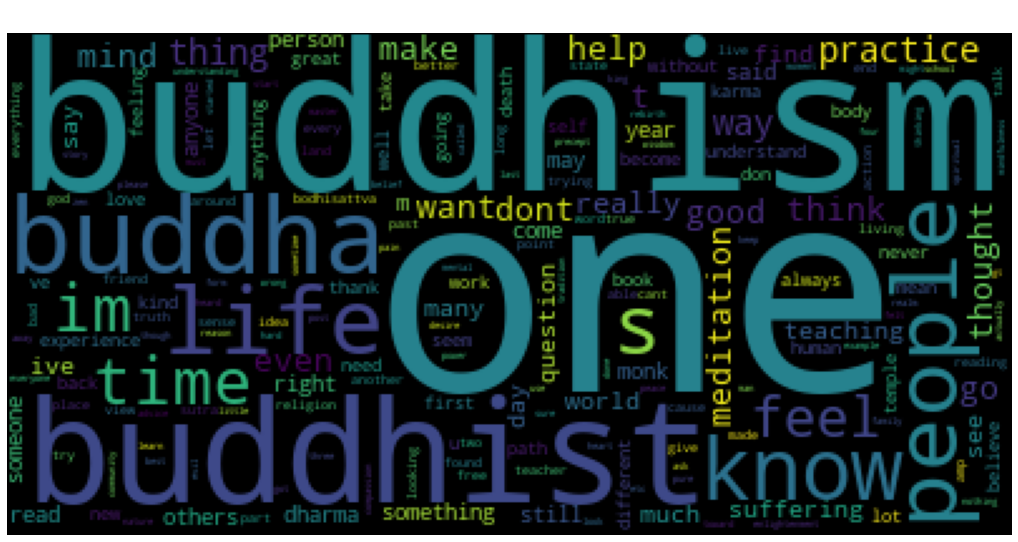

In [21]:
# Generate Wordcloud for Buddhism

wc = wordcloud.WordCloud(
    background_color='black',
    max_words=200,
    collocations=False
)
wc.generate(' '.join(
    text for text in subreddit_posts.loc[subreddit_posts["subreddit"] == 'Buddhism', "clean_text"]))
plt.figure(figsize=(18, 10))
plt.title('Top words in Buddhism subreddit',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()


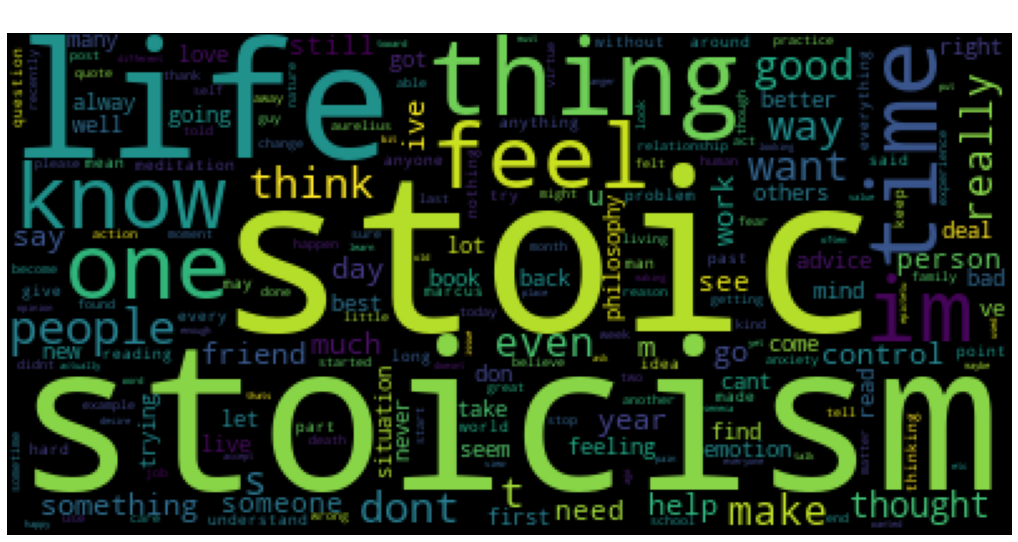

In [22]:
# Generate Wordcloud for Stoicism
wc = wordcloud.WordCloud(
    background_color='black',
    max_words=200,
    collocations=False
)
wc.generate(' '.join(
    text for text in subreddit_posts.loc[subreddit_posts["subreddit"] == 'Stoicism', "clean_text"]))
plt.figure(figsize=(18, 10))
plt.title('Top words in Stoicism subreddit',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()


In [23]:
# Top 30 words in Buddhism Subreddit

counter = Counter()
for text in subreddit_posts.loc[subreddit_posts['subreddit'] == 'Buddhism']['clean_text'].values:
    for word in text.split():
        counter[word] += 1
counter.most_common(30)

# Putting it into a dataframe
data_buddhism = dict(
    sorted(counter.items(), key=lambda x: x[1], reverse=True)[:30])

plot_df = pd.DataFrame.from_dict(data_buddhism, orient='index')

plot_df = plot_df.reset_index().rename(
    columns={"index": 'Word', 0: "Frequency"})

plot_df["Category"] = "Buddhism"

plot_df.head()


,Word,Frequency,Category
0,buddhism,3922,Buddhism
1,buddhist,3918,Buddhism
2,one,3905,Buddhism
3,like,3808,Buddhism
4,buddha,3437,Buddhism


In [24]:
# Top 30 words in Stoicism Subreddit

counter = Counter()
for text in subreddit_posts.loc[subreddit_posts['subreddit'] == 'Stoicism']['clean_text'].values:
    for word in text.split():
        counter[word] += 1
counter.most_common(30)

# Putting it into a dataframe
data_stoicism = dict(
    sorted(counter.items(), key=lambda x: x[1], reverse=True)[:30])

plot_df_2 = pd.DataFrame.from_dict(data_stoicism, orient='index')

plot_df_2 = plot_df_2.reset_index().rename(
    columns={"index": 'Word', 0: "Frequency"})

plot_df_2["Category"] = "Stoicism"

plot_df_2.head()


,Word,Frequency,Category
0,stoic,7651,Stoicism
1,like,6757,Stoicism
2,stoicism,6566,Stoicism
3,life,6484,Stoicism
4,thing,6162,Stoicism


In [25]:
# Concating the dataframes

plot_df = plot_df.append(plot_df_2)

plot_df.tail()


,Word,Frequency,Category
25,year,2644,Stoicism
26,help,2633,Stoicism
27,much,2505,Stoicism
28,go,2410,Stoicism
29,i’m,2345,Stoicism


[Text(0.5, 1.0, 'Top 30 words in each subreddit')]

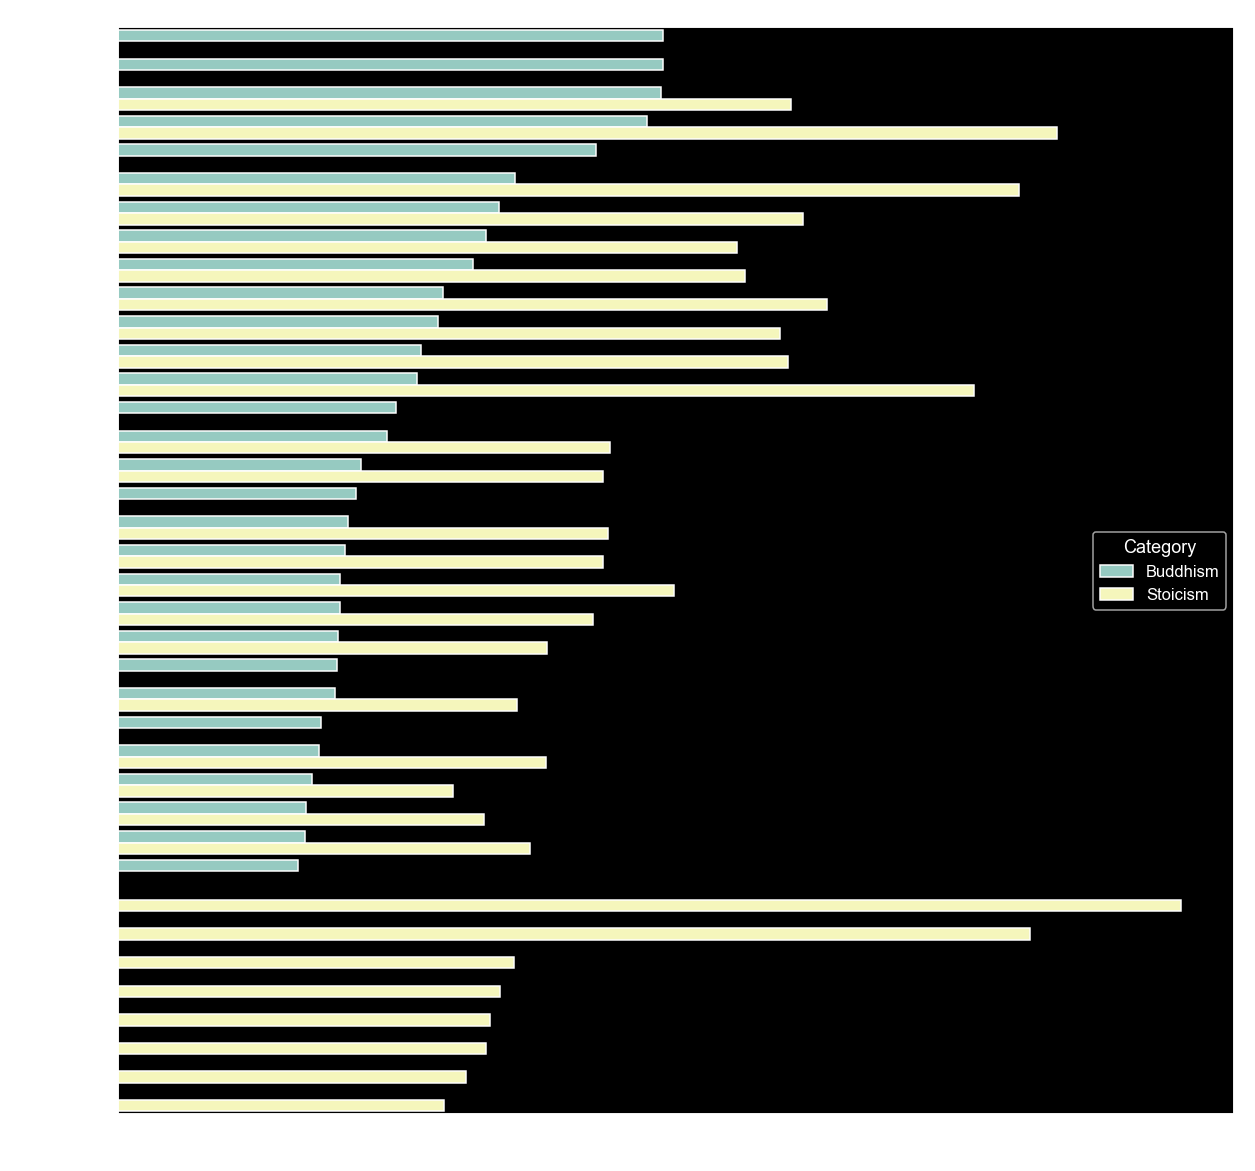

In [26]:
# Plotting a barplot
plt.figure(figsize=(20, 20))
sns.barplot(y='Word', x='Frequency', data=plot_df, hue='Category',
            orient='h').set(title='Top 30 words in each subreddit')


We see that there are a lot of common words between the two subreddits such as "one", "like", "life", "people", "time etc. Interestingly, it seems that the frequency of the most common words from the Stoicism subreddit is higher compared to the Buddhism Subreddit.

Looking at the unique words, the words 'Buddha', 'Buddhism' appearing in the Buddhism subreddit as well as the words 'Stoic', 'Stoicism' in the Stoicism subreddit is unsurprising. Interestingly, it would seem that the Buddhism subreddit has a larger focus on mind and meditation and suffering, while the Stoicism subreddit is more focused on control, and time (day, year). This could be an helpful insight into the areas of focus that each subreddit has when we conduct our topic modelling later on.


<b> Additional Stopwords</b>

We also see that there are still some stopwords in the text such as I'm and im. We will be removing these additional stopwords as well.


In [27]:
# Remove more stopwords
more_stopwords = ['nan', 'im', "i'm", 'u', 'ive']
stop_words = stop_words + more_stopwords
subreddit_posts["clean_text"] = subreddit_posts["clean_text"].apply(
    remove_stopwords)


## Message Length


We will now plot the distribution of the message length to see if there are relationships that we can sieve out.


In [28]:
# Find out word length in posts

subreddit_posts["message_length"] = subreddit_posts["clean_text"].apply(
    lambda x: len(str(x).split()))

subreddit_posts.head()


,subreddit,title,selftext,clean_text,message_length
0,Buddhism,Favorite teaching stories on the topic of Work as Meditation Practice?,I know I've heard some good stories related to **work as Buddhist practice** from different traditions over the years and would love to hear the stories that others in this community have collected or remembered over the years too.\n\nI'll submit some of my favorites in the comments below too... Thanks (in advance) for sharing!\n\n&amp;#x200B;\n\n&amp;#x200B;\n\nhttps://preview.redd.it/y6l7neqhfw291.jpg?width=2048&amp;format=pjpg&amp;auto=webp&amp;s=d8d8426d9d2132ee8737cdae0432dc73b2ad646b,favorite teaching story topic work meditation practice know heard good story related work buddhist practice different tradition year would love hear story others community collected remembered year tooill submit favorite comment thanks advance,33
1,Buddhism,"If you could ask our Buddha one question, what would it be?","For example, clarification whether our current iterpretation/translation of a specific sutta is accurate.",could ask buddha one question would example clarification whether current iterpretationtranslation specific sutta accurate,14
2,Buddhism,What are “signs?”,I am reading and have read some books that have mentioned signs without understanding what a sign is. What is a sign?,sign reading read book mentioned sign without understanding sign sign,10
3,Buddhism,Humor: The Present Moment,NaN,humor present moment,3
4,Buddhism,"What does ""devamāras"" mean?","I'm reading the BDK translation of the Lotus Sutra. On page 123, there is the following text:\n\n&gt;O Bhagavat! We request that you turn the wheel of the Dharma, thus causing the devamāras, Brahmas, śrāmaṇas, and brahmans to be at ease and saving them all!\n\nWhat does devamāras mean here exactly? Google shows me that sometime Māra is referred to as deva Māra or Devamāra--but no explanation for this more informal plural term. Is it just like saying ""devils"" versus ""The Devil,"" or is there something deeper?",devamāras mean reading bdk translation lotus sutra page following textgto bhagavat request turn wheel dharma thus causing devamāras brahma śrāmaṇas brahman ease saving allwhat devamāras mean exactly google show sometime māra referred deva māra devamārabut explanation informal plural term like saying devil versus devil something deeper,46


[Text(0.5, 1.0, 'Message Length Distribution')]

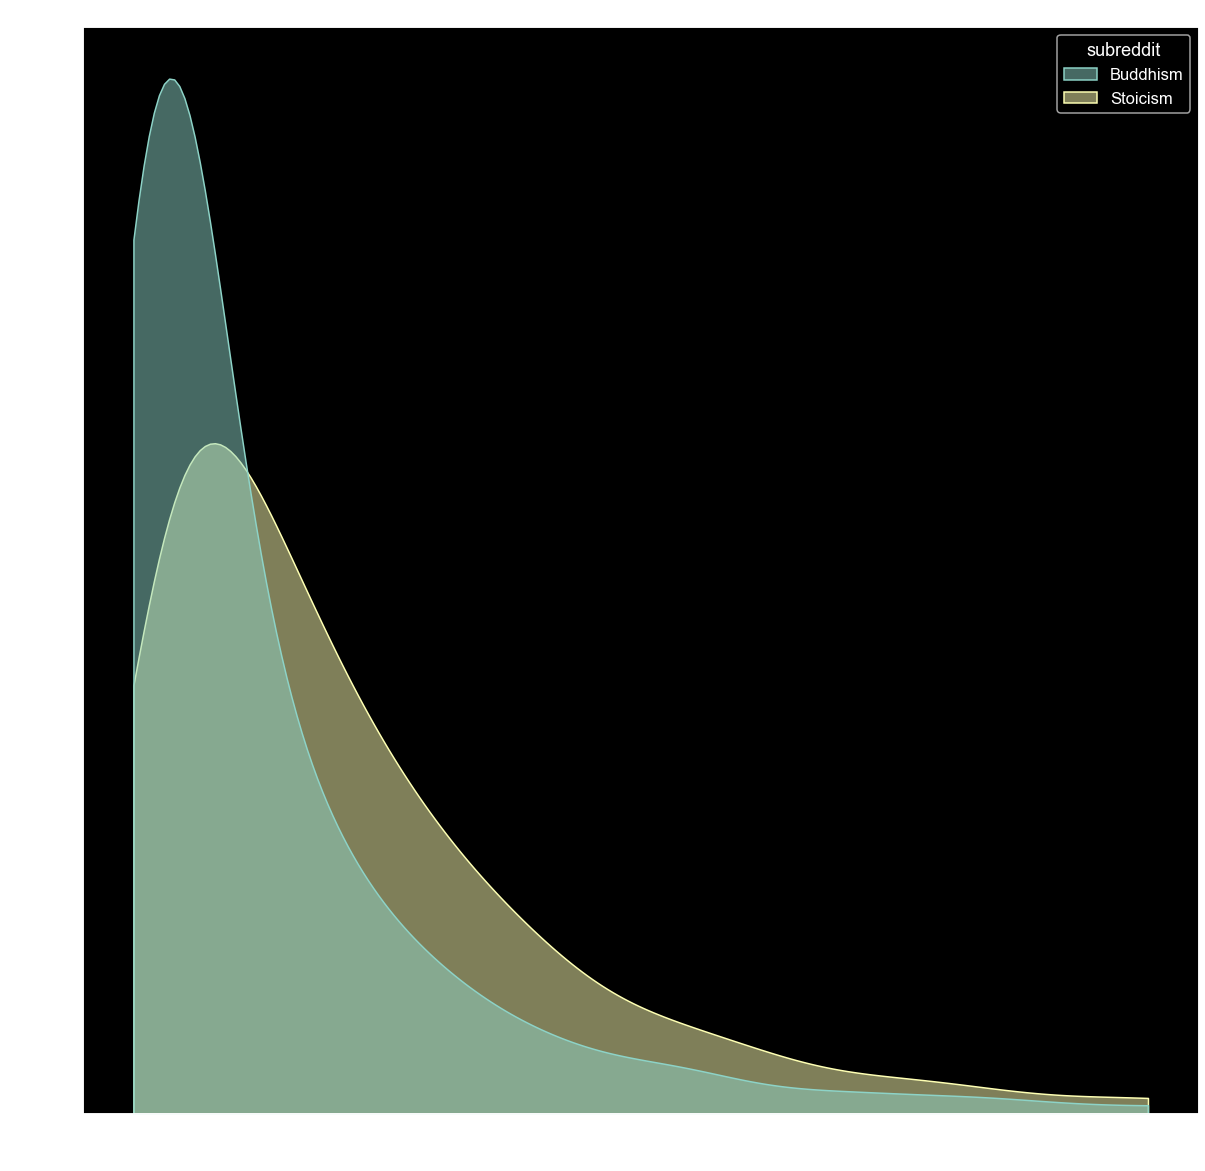

In [29]:
# Visualise the message length distribution

plt.figure(figsize=(20, 20))

sns.kdeplot(data=subreddit_posts, x="message_length",
            hue="subreddit", alpha=0.5, fill=True, clip=(0, 300)).set(title="Message Length Distribution")


Interestingly, we see that the average message length of the Buddhism subreddit is lower than the Stoicism subreddit.


Lastly, we will be dropping all rows that are blank or are duplicates after all the preprocessing.


In [30]:
# Drop blank rows
subreddit_posts = subreddit_posts.drop(
    subreddit_posts[(subreddit_posts["message_length"] < 1)].index)


#Drop Duplicate Rows
subreddit_posts.drop_duplicates(keep='first', inplace=True)

subreddit_posts.shape


(19642, 5)

We see that ultimately we are left with a dataset of with 19,642 rows.


---

# Data Encoding


We will now use the Label Encoder to convert our subreddit categories into 1 and 0 so that the machine will be able to train. We have designated 0 as posts from the Buddhism subreddit, and 1 as posts from the Stoicism subreddit.


In [31]:
# Label Encode the Subreddit
le = LabelEncoder()

subreddit_posts['subreddit'] = le.fit_transform(subreddit_posts['subreddit'])

subreddit_posts.head()


,subreddit,title,selftext,clean_text,message_length
0,0,Favorite teaching stories on the topic of Work as Meditation Practice?,I know I've heard some good stories related to **work as Buddhist practice** from different traditions over the years and would love to hear the stories that others in this community have collected or remembered over the years too.\n\nI'll submit some of my favorites in the comments below too... Thanks (in advance) for sharing!\n\n&amp;#x200B;\n\n&amp;#x200B;\n\nhttps://preview.redd.it/y6l7neqhfw291.jpg?width=2048&amp;format=pjpg&amp;auto=webp&amp;s=d8d8426d9d2132ee8737cdae0432dc73b2ad646b,favorite teaching story topic work meditation practice know heard good story related work buddhist practice different tradition year would love hear story others community collected remembered year tooill submit favorite comment thanks advance,33
1,0,"If you could ask our Buddha one question, what would it be?","For example, clarification whether our current iterpretation/translation of a specific sutta is accurate.",could ask buddha one question would example clarification whether current iterpretationtranslation specific sutta accurate,14
2,0,What are “signs?”,I am reading and have read some books that have mentioned signs without understanding what a sign is. What is a sign?,sign reading read book mentioned sign without understanding sign sign,10
3,0,Humor: The Present Moment,NaN,humor present moment,3
4,0,"What does ""devamāras"" mean?","I'm reading the BDK translation of the Lotus Sutra. On page 123, there is the following text:\n\n&gt;O Bhagavat! We request that you turn the wheel of the Dharma, thus causing the devamāras, Brahmas, śrāmaṇas, and brahmans to be at ease and saving them all!\n\nWhat does devamāras mean here exactly? Google shows me that sometime Māra is referred to as deva Māra or Devamāra--but no explanation for this more informal plural term. Is it just like saying ""devils"" versus ""The Devil,"" or is there something deeper?",devamāras mean reading bdk translation lotus sutra page following textgto bhagavat request turn wheel dharma thus causing devamāras brahma śrāmaṇas brahman ease saving allwhat devamāras mean exactly google show sometime māra referred deva māra devamārabut explanation informal plural term like saying devil versus devil something deeper,46


We will now zip the preprocessed data into a clean csv for our topic modelling in future.


In [32]:
# Zip to clean CSV

subreddit_posts.to_csv("subreddit_posts_preprocessed.csv", index=False)


Now we check the number of posts from each subreddit.

In [33]:
subreddit_posts['subreddit'].value_counts()


1    9835
0    9807
Name: subreddit, dtype: int64

Our final dataset is quite balanced and hence we don't have to stratify them when we split our data.


---

# Classification Modelling


Now that we have preprocessed our data, we will be training several machine learning models to determine which will give us the best accuracy. We will be using accuracy, precision and recall as our key metrics to evaluate our model. We will be prioritising accuracy given we are more concerned about properly classifing our posts and there are no major downsides if our app incorrectly classifies.


We will be choosing the following models to assess our data:

1. Logistic Regression
2. Multinomial Naive-Bayes
3. K Nearest Neighbors Classifier
4. Support Vector Machines
5. Random Forest Classifier
6. Bagging Classifier
7. Light GBM Classifier
8. Multi-Layer Perceptron Classifier


<b> Vectorizer </b>

We will first use the TF-IDF vectorizer to help us transform our data. Given that there are a lot of unique terms for each subreddit, TF-IDF vectorizer would be more appropriate to help minimise terms that are scattered throughout the different posts. We have set the vectorizer to consider both unigrams and bigrams, and to remove any further stopwords.

<b> Select K Best </b>

We will also use the SelectKBest function to initiate a chi-square test to reduce the number of features to reduce our model's dimensions.


<b> Pipeline </b>

Lastly, we will be creating a pipeline to fit and transform our data. First, we set our model parameters for the different models. Given the number of models, we will have to limit the number of parameters in order to reduce the speed that it takes for python to loop through.


In [34]:
# Set parameters of models
models = pd.DataFrame(columns=['name', 'model', 'param_grid'])


# Logistic Regression
n = 0
models.loc[n, 'name'] = 'Logistic Regression'
models.at[n, 'model'] = LogisticRegression()
models.at[n, 'param_grid'] = {'model__C': np.linspace(0.0001, 100, 20),
                              'tvec__stop_words': ['english'],
                              'tvec__ngram_range': [(1, 2)],
                              'tvec__max_df': [1.0, 0.8, 0.5],
                              'skb__k': [10000, 2000, 1000],
                              }


# Multinomial NB
n = 1
models.loc[n, 'name'] = 'Multinomial NB'
models.at[n, 'model'] = MultinomialNB()
models.at[n, 'param_grid'] = {'tvec__stop_words': ['english'],
                              'tvec__ngram_range': [(1, 2)],
                              'tvec__max_df': [1.0, 0.8, 0.5, ],
                              'skb__k': [10000, 2000, 1000]
                              }

# KNN Classifier
n = 2
models.loc[n, 'name'] = 'KNN Classifier'
models.at[n, 'model'] = KNeighborsClassifier()
models.at[n, 'param_grid'] = {'model__n_neighbors': [3, 5, 7, 9],
                              'model__weights': ['uniform', 'distance'], 'tvec__stop_words': ['english'],
                              'tvec__ngram_range': [(1, 2)],
                              'tvec__max_df': [1.0, 0.8, 0.5, ],
                              'skb__k': [10000, 2000, 1000]
                              }


# Support Vector Machines
n = 3
models.loc[n, 'name'] = 'Support Vector Machines'
models.at[n, 'model'] = SVC()
models.at[n, 'param_grid'] = {'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                              'model__tol': [1e-3], 'tvec__stop_words': ['english'],
                              'tvec__ngram_range': [(1, 2)],
                              'tvec__max_df': [1.0, 0.8, 0.5, ],
                              'skb__k': [10000, 2000, 1000]
                              }

# Random Forest Classifier
n = 4
models.loc[n, 'name'] = 'Random Forest Classifier'
models.at[n, 'model'] = RandomForestClassifier()
models.at[n, 'param_grid'] = {'model__n_estimators': [100, 300, 500],
                              'model__min_samples_split': [100, 200, 300, 400],
                              'model__min_samples_leaf': [15, 20, 50, 100],
                              'model__max_depth': [None],
                              'model__criterion': ['gini'],
                              'model__bootstrap': [False], 'tvec__stop_words': ['english'],
                              'tvec__ngram_range': [(1, 2)],
                              'tvec__max_df': [1.0, 0.8, 0.5],
                              'skb__k': [10000, 2000, 1000]
                              }

# Bagging Classifier
n = 5
models.loc[n, 'name'] = 'Bagging Classifier'
models.at[n, 'model'] = BaggingClassifier()
models.at[n, 'param_grid'] = {'model__max_features': np.linspace(0.05, 0.8, 1),
                              'model__warm_start': [False], 'tvec__stop_words': ['english'],
                              'tvec__ngram_range': [(1, 2)],
                              'tvec__max_df': [1.0, 0.8, 0.5],
                              'skb__k': [10000, 2000, 1000]
                              }
# LGBM Classifier
n = 6
models.loc[n, 'name'] = 'LGBM Classifier'
models.at[n, 'model'] = lgb.LGBMClassifier(boosting_type='gbdt',
                                           objective='binary'
                                           )
models.at[n, 'param_grid'] = {'model__n_estimators': [100, 500, 1000],
                              'model__num_leaves': [30, 50, 100],
                              'model__learning_rate': [0.01], 'tvec__stop_words': ['english'],
                              'tvec__ngram_range': [(1, 2)],
                              'tvec__max_df': [1.0, 0.8, 0.5],
                              'skb__k': [10000, 2000, 1000]
                              }
# MLP Classifier
n = 7
models.loc[n, 'name'] = 'MLPClassifier'
models.at[n, 'model'] = MLPClassifier()
models.at[n, 'param_grid'] = {'model__hidden_layer_sizes': [i for i in range(2, 10)],
                              'model__solver': ['adam'],
                              'model__learning_rate': ['adaptive'],
                              'model__max_iter': [250, 500, 1000], 'tvec__stop_words': ['english'],
                              'tvec__ngram_range': [(1, 2)],
                              'tvec__max_df': [1.0, 0.8, 0.5],
                              'skb__k': [10000,  2000, 1000]
                              }

# Avg values
models.loc[8, 'name'] = 'Mean values'

# Max values
models.loc[9, 'name'] = 'Max values'

models


,name,model,param_grid
0,Logistic Regression,LogisticRegression(),"{'model__C': [0.0001, 5.263252631578947, 10.526405263157894, 15.789557894736841, 21.05271052631579, 26.315863157894736, 31.579015789473683, 36.842168421052634, 42.10532105263158, 47.36847368421053, 52.631626315789475, 57.89477894736842, 63.15793157894737, 68.42108421052632, 73.68423684210526, 78.94738947368421, 84.21054210526316, 89.4736947368421, 94.73684736842105, 100.0], 'tvec__stop_words': ['english'], 'tvec__ngram_range': [(1, 2)], 'tvec__max_df': [1.0, 0.8, 0.5], 'skb__k': [10000, 2000, 1000]}"
1,Multinomial NB,MultinomialNB(),"{'tvec__stop_words': ['english'], 'tvec__ngram_range': [(1, 2)], 'tvec__max_df': [1.0, 0.8, 0.5], 'skb__k': [10000, 2000, 1000]}"
2,KNN Classifier,KNeighborsClassifier(),"{'model__n_neighbors': [3, 5, 7, 9], 'model__weights': ['uniform', 'distance'], 'tvec__stop_words': ['english'], 'tvec__ngram_range': [(1, 2)], 'tvec__max_df': [1.0, 0.8, 0.5], 'skb__k': [10000, 2000, 1000]}"
3,Support Vector Machines,SVC(),"{'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'model__tol': [0.001], 'tvec__stop_words': ['english'], 'tvec__ngram_range': [(1, 2)], 'tvec__max_df': [1.0, 0.8, 0.5], 'skb__k': [10000, 2000, 1000]}"
4,Random Forest Classifier,RandomForestClassifier(),"{'model__n_estimators': [100, 300, 500], 'model__min_samples_split': [100, 200, 300, 400], 'model__min_samples_leaf': [15, 20, 50, 100], 'model__max_depth': [None], 'model__criterion': ['gini'], 'model__bootstrap': [False], 'tvec__stop_words': ['english'], 'tvec__ngram_range': [(1, 2)], 'tvec__max_df': [1.0, 0.8, 0.5], 'skb__k': [10000, 2000, 1000]}"
5,Bagging Classifier,BaggingClassifier(),"{'model__max_features': [0.05], 'model__warm_start': [False], 'tvec__stop_words': ['english'], 'tvec__ngram_range': [(1, 2)], 'tvec__max_df': [1.0, 0.8, 0.5], 'skb__k': [10000, 2000, 1000]}"
6,LGBM Classifier,LGBMClassifier(objective='binary'),"{'model__n_estimators': [100, 500, 1000], 'model__num_leaves': [30, 50, 100], 'model__learning_rate': [0.01], 'tvec__stop_words': ['english'], 'tvec__ngram_range': [(1, 2)], 'tvec__max_df': [1.0, 0.8, 0.5], 'skb__k': [10000, 2000, 1000]}"
7,MLPClassifier,MLPClassifier(),"{'model__hidden_layer_sizes': [2, 3, 4, 5, 6, 7, 8, 9], 'model__solver': ['adam'], 'model__learning_rate': ['adaptive'], 'model__max_iter': [250, 500, 1000], 'tvec__stop_words': ['english'], 'tvec__ngram_range': [(1, 2)], 'tvec__max_df': [1.0, 0.8, 0.5], 'skb__k': [10000, 2000, 1000]}"
8,Mean values,NaN,NaN
9,Max values,NaN,NaN


We then create a function that will loop through the different models and produce the best parameters and scores.


In [35]:
def model_prediction(models, features, labels, test_size, verbose):
    # Models training and data prediction for all models from DataFrame models

    # Splitting train data for model tuning with cross-validation
    #cv_train = ShuffleSplit(n_splits=cv_n_split, test_size=0.2, random_state=random_state)
    train_features, test_features, train_labels, test_labels = train_test_split(features,
                                                                                labels,
                                                                                test_size=test_size,
                                                                                random_state=42)

    # Total list of prediction by all models
    total_train_pred = []
    total_test_pred = []

    # Results
    results = models[['name']].copy()
    results['acc_train'] = results['acc_test'] = 0
    results['prec_train'] = results['prec_test'] = 0
    results['recall_train'] = results['recall_test'] = 0

    for i in (range(len(models)-2)):
        # Training
        pipe = Pipeline([
            ('tvec', TfidfVectorizer()),
            ('skb', SelectKBest(chi2)),
            ('model', models.at[i, 'model'])
        ])

        gs = GridSearchCV(pipe,  # what object are we optimizing?
                          # what parameters values are we searching?
                          param_grid=models.at[i, 'param_grid'],
                          cv=5, n_jobs=-1, )
        gs.fit(train_features, train_labels)

        # Prediction

        train_pred = gs.predict(train_features).round(0).astype('int')
        total_train_pred.append(train_pred)
        test_pred = gs.predict(test_features).round(0).astype('int')
        total_test_pred.append(test_pred)

        # Scoring
        acc_train = accuracy_score(train_labels, train_pred)
        acc_test = accuracy_score(test_labels, test_pred)
        prec_train = precision_score(train_labels, train_pred)
        prec_test = precision_score(test_labels, test_pred)
        recall_train = recall_score(train_labels, train_pred)
        recall_test = recall_score(test_labels, test_pred)

        if verbose:
            print(f"Model - {models.loc[i, 'name']}")
            print("Best parameters:", gs.best_params_)
            print("Accuracy for training data: %0.3f" % acc_train)
            print("Accuracy for test data: %0.3f" % acc_test)
            print("Precision for training data: %0.3f" % prec_train)
            print("Precision for test data: %0.3f" % prec_test)
            print("Recall for training data: %0.3f" % recall_train)
            print("Recall for test data: %0.3f" % recall_test)
            print('\n')

        # Save results
        results.loc[i, 'acc_train'] = acc_train
        results.loc[i, 'acc_test'] = acc_test
        results.loc[i, 'prec_train'] = prec_train
        results.loc[i, 'prec_test'] = prec_test
        results.loc[i, 'recall_train'] = recall_train
        results.loc[i, 'recall_test'] = recall_test

    # MEAN values
    # Calc prediction
    mean_train_pred = (np.mean(np.array(total_train_pred), axis=0)).astype(int)
    mean_test_pred = (np.mean(np.array(total_test_pred), axis=0)).astype(int)

    # Scoring
    acc_train = accuracy_score(train_labels, mean_train_pred)
    acc_test = accuracy_score(test_labels, mean_test_pred)
    prec_train = precision_score(train_labels, mean_train_pred)
    prec_test = precision_score(test_labels, mean_test_pred)
    recall_train = recall_score(train_labels, mean_train_pred)
    recall_test = recall_score(test_labels, mean_test_pred)
    if verbose:
        print(f"Mean prediction values")
        print("Accuracy for training data: %0.3f" % acc_train)
        print("Accuracy for test data: %0.3f" % acc_test)
        print("Precision for training data: %0.3f" % prec_train)
        print("Precision for test data: %0.3f" % prec_test)
        print("Recall for training data: %0.3f" % recall_train)
        print("Recall for test data: %0.3f" % recall_test)
        print('\n')

    # Save results
    n = len(results)-2
    results.loc[n, 'acc_train'] = acc_train
    results.loc[n, 'acc_test'] = acc_test
    results.loc[n, 'prec_train'] = prec_train
    results.loc[n, 'prec_test'] = prec_test
    results.loc[n, 'recall_train'] = recall_train
    results.loc[n, 'recall_test'] = recall_test

    # MAX values
    # Calc prediction
    max_train_pred = (np.max(np.array(total_train_pred), axis=0))
    max_test_pred = (np.max(np.array(total_test_pred), axis=0))

    # Scoring
    acc_train = accuracy_score(train_labels, max_train_pred)
    acc_test = accuracy_score(test_labels, max_test_pred)
    prec_train = precision_score(train_labels, max_train_pred)
    prec_test = precision_score(test_labels, max_test_pred)
    recall_train = recall_score(train_labels, max_train_pred)
    recall_test = recall_score(test_labels, max_test_pred)
    if verbose:
        print(f"Maximum prediction values")
        print("Accuracy for training data: %0.3f" % acc_train)
        print("Accuracy for test data: %0.3f" % acc_test)
        print("Precision for training data: %0.3f" % prec_train)
        print("Precision for test data: %0.3f" % prec_test)
        print("Recall for training data: %0.3f" % recall_train)
        print("Recall for test data: %0.3f" % recall_test)

    # Save results
    n = len(results)-1
    results.loc[n, 'acc_train'] = acc_train
    results.loc[n, 'acc_test'] = acc_test
    results.loc[n, 'prec_train'] = prec_train
    results.loc[n, 'prec_test'] = prec_test
    results.loc[n, 'recall_train'] = recall_train
    results.loc[n, 'recall_test'] = recall_test

    return results


In [36]:
def target_prediction(models, df, features, target, test_size=0.2, verbose=True):
    # Text classification model and prediction for given feature "target" (with labels) in df

    # Target
    labels = df[target]

    # Models training, prediction and save results
    results = model_prediction(
        models, features, labels, test_size, verbose=verbose)
    results = results.sort_values(
        by=['acc_test', 'acc_train'], ascending=False)
    display(results)


In [ ]:
target_prediction(models, subreddit_posts,
                  subreddit_posts["clean_text"], 'subreddit', 0.2, verbose=True)


Model - Logistic Regression
Best parameters: {'model__C': 15.789557894736841, 'skb__k': 10000, 'tvec__max_df': 1.0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
Accuracy for training data: 0.973
Accuracy for test data: 0.934
Precision for training data: 0.976
Precision for test data: 0.929
Recall for training data: 0.971
Recall for test data: 0.939


Model - Multinomial NB
Best parameters: {'skb__k': 2000, 'tvec__max_df': 1.0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
Accuracy for training data: 0.889
Accuracy for test data: 0.882
Precision for training data: 0.827
Precision for test data: 0.818
Recall for training data: 0.985
Recall for test data: 0.983


Model - KNN Classifier
Best parameters: {'model__n_neighbors': 9, 'model__weights': 'distance', 'skb__k': 1000, 'tvec__max_df': 1.0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
Accuracy for training data: 0.992
Accuracy for test data: 0.805
Precision for training data: 1.000
Precision 

,name,acc_train,acc_test,prec_train,prec_test,recall_train,recall_test
0,Logistic Regression,0.973271,0.933825,0.975628,0.929293,0.970921,0.938776
6,LGBM Classifier,0.955896,0.928481,0.978290,0.941610,0.932698,0.913265
3,Support Vector Machines,0.981417,0.927717,0.985654,0.939203,0.977143,0.914286
7,MLPClassifier,0.946350,0.926953,0.958290,0.928315,0.933587,0.925000
4,Random Forest Classifier,0.921912,0.905574,0.936909,0.910170,0.905143,0.899490
1,Multinomial NB,0.889136,0.882413,0.827024,0.817912,0.984762,0.983163
9,Max values,0.885954,0.816493,0.814822,0.733862,0.999619,0.991837
2,KNN Classifier,0.991663,0.805294,0.999871,0.906186,0.983492,0.680102
5,Bagging Classifier,0.931203,0.763553,0.991749,0.806298,0.869968,0.692347
8,Mean values,0.906192,0.734284,1.000000,0.985169,0.812825,0.474490


## Results

As can be seen, Logistic Regression seems to perform the best with a 93.38% accuracy on our test data. We will use the logistic regression model as having a false negative or false positive is not detrimental to the app. A logistic regression model, which is an innate probabilistic model,also will allow us to dynamically adjust the threshold to better fit individual users and correct wrong prompt.  It also has a 92.29% precision score and a 93.88% recall, which is really good. We can use that to predict onto our test set and determine the scores, and plot a confusion matrix on the results of our prediction.


In [37]:
# Predict on our test set

X = subreddit_posts["clean_text"]
y = subreddit_posts["subreddit"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=123, test_size=0.25)


pipe_lr = Pipeline([
    ('tvec', TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_df=1.0)),
    ('skb', SelectKBest(chi2, k=10000)),
    ('model', LogisticRegression(C = 15.789557894736841))
])

model = pipe_lr.fit(X_train, y_train)

y_pred = model.predict(X_test)


Accuracy = 0.921808185705559
Precision = 0.9120792079207921
Recall = 0.9342799188640973


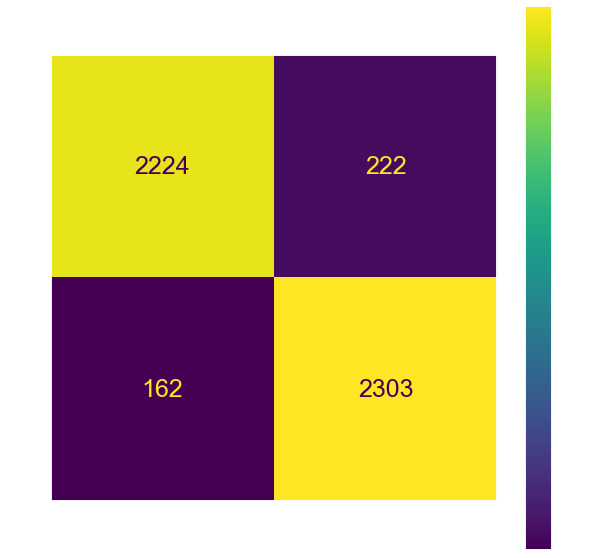

In [38]:
# Print Accuracy Score and Confusion Matrix

print(f"Accuracy = {accuracy_score(y_test, y_pred)}")
print(f"Precision = {precision_score(y_test, y_pred)}")
print(f"Recall = {recall_score(y_test, y_pred)}")

disp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred))
fig, ax = plt.subplots(figsize = (10,10))
plt.rcParams.update({'font.size': 25})
ax.set_title("Confusion Matrix")
disp.plot(ax = ax)


Our model on our test set has reached accuracy score of 92.18%. We will first look into the false positives and false negatives in detail. We will also extract the top 20 feature importance from the model.

In [40]:
# Create dataframe on the test to see the false positives and negatives
df_test = pd.DataFrame(X_test)
df_test['case'] = np.where((y_test == 1) & (y_pred == 0), 'False Negative',
                           np.where((y_test == 0) & (y_pred == 1), 'False Positive', 'Correct Prediction'))

In [41]:
df_test.loc[df_test['case'] == 'False Negative'].head()

,clean_text,case
10147,people treat reflection don’t know accurate phrased please correct,False Negative
14379,let people get skin especially come racist joke,False Negative
17751,would great book beginner,False Negative
11343,use curse word,False Negative
19766,please help deeper understanding indifference,False Negative


In [42]:
df_test.loc[df_test['case'] == 'False Positive'].head()

,clean_text,case
3305,liberate oneself destructive emotion meditation i’ve often read one must examine feeling rather object feeling don’t quite understand mean i’m sure i’m examining feeling productive wayi find i’m good seeing root certain emotion haven’t yet realized ephemeral nature meditation session advice,False Positive
898,unfriendly people handle new person entered social circle week ago tried introduce warmly kinda quasiwalked could talk properly didnt think anything night friend carried seemed really rude time let slidewe went next place friend sitting outside rest friend bar walk outdoor area appearing lost spotted walked let know sitting outside blow walk back inside rude manner someone didnt know plaguei really rubbed wrong way especially since positive nothing wrong trying give welcoming precense friend gave first met meant lot time person regular group trying evaluate proceed since imguaranteed see disassociate peacefully try converse sure take another shunning hurt alot last time,False Positive
4896,started reading shōbōgenzō dōgen worth time book recommendation,False Positive
2803,struggling right thought right speech come family pretty dysfunctional familywhenever spend time find judging psychoanalyzing flaw find easy graceful amp nonjudgmental friend stranger however come family find habor lot anger towards know extent negligence carelessness immaturity etcbecause i’ve known long know well work reading help drop judgement towards family one overcome constantly see family thanks advance help,False Positive
5544,please keep country best thought help spread unity dont know else vent heart hurt everything going try think thing stay positive hard family ukraine grandma life krasnodon every day cry watching news hoping nothing happen hoping russia doesnt step foot crimea mom cant sleep cant think straight unfair cant believe lie people believe hate message russian brainwashed propaganda poor people forced partake war dont want civilian choice defend country teacher known long love turned crazy patriot defending putin mom tell people talked regularly saying horrible thing towards ukraine see dancer follow posting video cry fleeing poland constant fear hard look cant turn head away winner war greed one person expense others,False Positive


It seems that the model is mainly classifying the posts incorrectly based on the message length of the posts. This makes sense given that the Buddhism subreddit tends to have posts with lesser number of words compared to the Stoicism subreddit.

In [ ]:
# Get Feature importance

feature_names = pipe_lr.named_steps["tvec"].get_feature_names()
feature_importance = pipe_lr.named_steps["model"].coef_.flatten()

# Zip feature importance and names together and make a DataFrame
zipped = zip(feature_names, feature_importance)
df = pd.DataFrame(zipped, columns=["feature", "value"])

# Sort the features by the absolute value
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 7875 to 4713
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature    10000 non-null  object 
 1   value      10000 non-null  float64
 2   abs_value  10000 non-null  float64
 3   colors     10000 non-null  object 
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


Text(0.5, 0, 'Feature Coefficients')

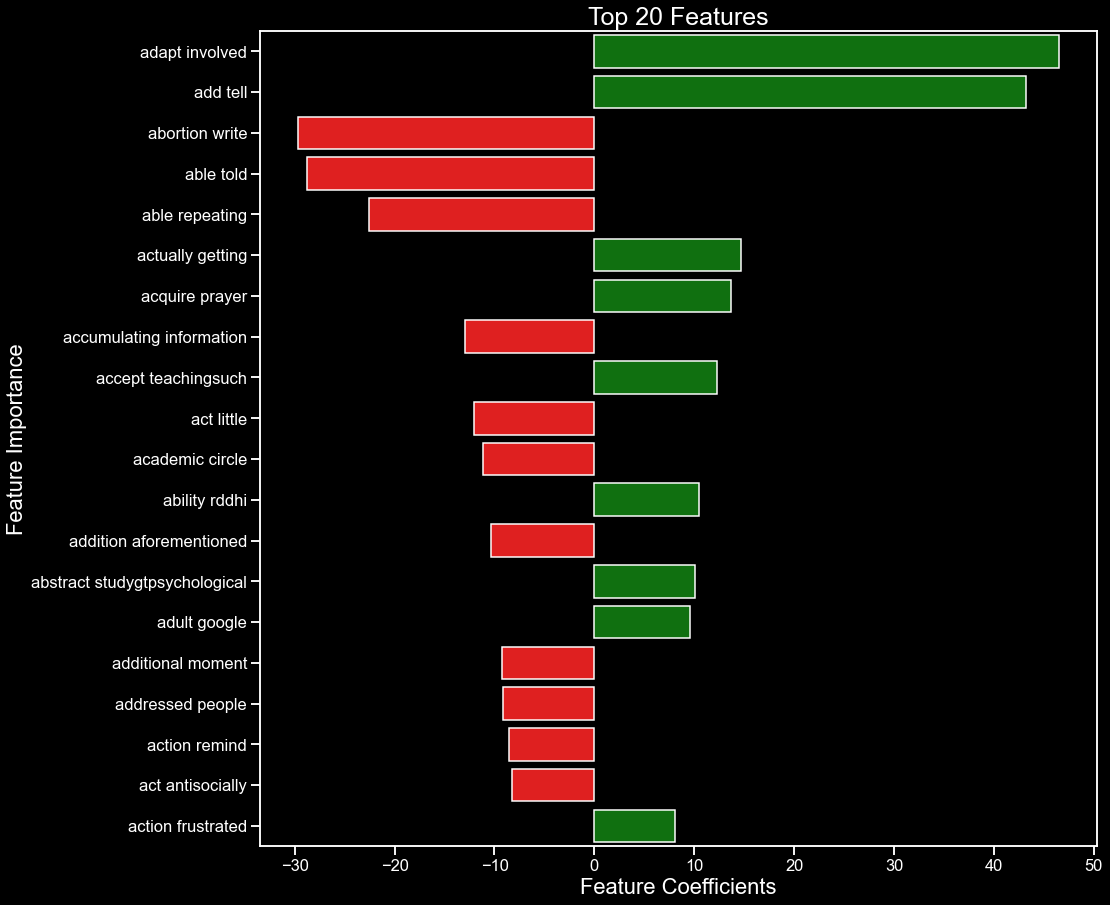

In [ ]:
#Plot the features on a graph 

fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(y="feature",
            x="value",
            data=df.head(20),
            palette=df.head(20)["colors"])
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Feature Importance", fontsize=22)
ax.set_xlabel("Feature Coefficients", fontsize=22)


We see that the top 20 features that contribute to the model gives quite a good balance between positive and negative coefficients.

# Summary

The logistic regression model has given us a good accuracy metric to distinguish between users who are more aligned to either Buddhism and Stoicism. From here, we can continue to distill more insights to see if we can be identify running topics that are common or different in the subreddits. 